In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, learning_curve, StratifiedKFold
from pprint import pprint
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import warnings
# Ignore all future warnings
import sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.2.


## Data Preprocessing

In [2]:
# Loading data into dataframes
def data_preprocessing(file_name):
    df = pd.read_csv(file_name)
    df.reset_index(drop=True)
    df = df.drop(df.columns[0], axis=1)
    return df

word_embed_train = data_preprocessing('384EMBEDDINGS_TRAIN.csv')
word_embed_test = data_preprocessing('384EMBEDDINGS_TEST.csv')
word_embed_validation = data_preprocessing('384EMBEDDINGS_VALIDATION.csv')

tfidf_train = data_preprocessing('TFIDF_TRAIN.csv')
tfidf_test = data_preprocessing('TFIDF_TEST.csv')
tfidf_validation = data_preprocessing('TFIDF_VALIDATION.csv')

train_data = data_preprocessing('TRAIN.csv')
test_data = data_preprocessing('TEST_NO_LABELS.csv')
validation_data = data_preprocessing('VALIDATION.csv')

In [3]:
# Setting up Train and Test dataset
y_train = train_data['rating'] # Train labels
y_vad = validation_data['rating'] # Validation labels
X_train = train_data.drop('rating', axis=1)
X_vad = validation_data.drop('rating', axis=1)

X_train_embed = word_embed_train # Train features for word embedding
X_vad_embed = word_embed_validation #Validate features

X_train_tf = tfidf_train # Train features for tfidf
X_vad_tf = tfidf_validation # Validate features

X_train_all = pd.concat([word_embed_train, tfidf_train],axis=1)
X_vad_all = pd.concat([word_embed_validation,tfidf_validation], axis=1)

In [4]:
all_column_names = X_train_all.columns
scaler = StandardScaler()
scaler.fit(X_train_all)
X_train_all_scaled = scaler.transform(X_train_all)
X_vad_all_scaled = scaler.transform(X_vad_all)
X_train_all_scaled = pd.DataFrame(X_train_all_scaled, columns=all_column_names)
X_vad_all_scaled = pd.DataFrame(X_vad_all_scaled, columns=all_column_names)

# Standarize Word Embed data so it's non-negative
mnb_scaler = MinMaxScaler()
mnb_scaler.fit(X_train_all)
X_train_mnb_base = mnb_scaler.transform(X_train_all)
X_vad_mnb_base = mnb_scaler.transform(X_vad_all)
X_train_mnb_base = pd.DataFrame(X_train_mnb_base, columns=all_column_names)
X_vad_mnb_base = pd.DataFrame(X_vad_mnb_base, columns=all_column_names)

In [5]:
# Evaluation
# Get scores for the model
def get_scores(pred_label, true_label, average='macro'):
    # Accuracy
    accuracy = metrics.accuracy_score(true_label, pred_label)
    # Precision, Recall and F1-score (default: macro average)
    score_report = metrics.precision_recall_fscore_support(true_label, pred_label, average=average, zero_division=0) 
    # Confusion Matrix 
    confusion = metrics.confusion_matrix(true_label, pred_label)       
    return accuracy, score_report, confusion 

def plot_cm(plot_name,confusion):
    plt.figure(figsize=(4, 2))
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted ratings');ax.set_ylabel('True ratings'); 
    ax.set_title(plot_name); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

def plot_learning_curve(plot_name, estimator, X_train, y_train, fold=5, scoring='f1_macro'):
    '''
    Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
    '''
    train_sizes, train_scores, valid_scores = learning_curve(estimator,X_train, 
                                                             y_train, scoring=scoring, cv=StratifiedKFold(fold),
                                                             train_sizes=np.linspace(0.1, 1.0, 5))
    print(f"Train scores: {np.round(np.mean(train_scores, axis=1),4)}")
    print(f"Validation scores: {np.round(np.mean(valid_scores, axis=1),4)}")
    plt.figure(figsize=(4, 3))
    plt.xlabel("training size")
    plt.ylabel("accuracy")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0,1.1,step=0.1))
    plt.grid(visible=True)
    plt.title(plot_name)
    plt.legend(loc="best")
    plt.show()

def display_performance(plot_name, pred_label, true_label):
    accuracy, scores, cm = get_scores(pred_label, true_label)
    print("Accuracy: ", round(accuracy,4))
    print("Precision: ", round(scores[0],4))
    print("Recall: ", round(scores[1],4))
    print("F1 : ", round(scores[2],4))
    plot_cm(plot_name, cm)

# Mismatched Reivew Examples
pd.set_option('display.max_colwidth', None)
def getMismatch(pred, sample_size):
    pred_df = pd.DataFrame(pred, columns=["prediction"])
    pred_df = pd.concat([validation_data, pred_df],axis=1)
    mismatched = pred_df.loc[pred_df["rating"] != pred_df["prediction"]]
    false_positive = mismatched.loc[mismatched["prediction"] == 1]
    false_negative = mismatched.loc[mismatched["prediction"] == -1]
    print("False Positive:")
    display(false_positive.head(sample_size))
    print("False Negative:")
    display(false_negative.head(sample_size))
    return false_positive, false_negative

Value Ranges:
Combined features: [-10.390859103325745, 40.162175901201316]
Word Embeddings: [-0.29050294, 0.40621856]
TF-IDF: [0.0, 1.0]


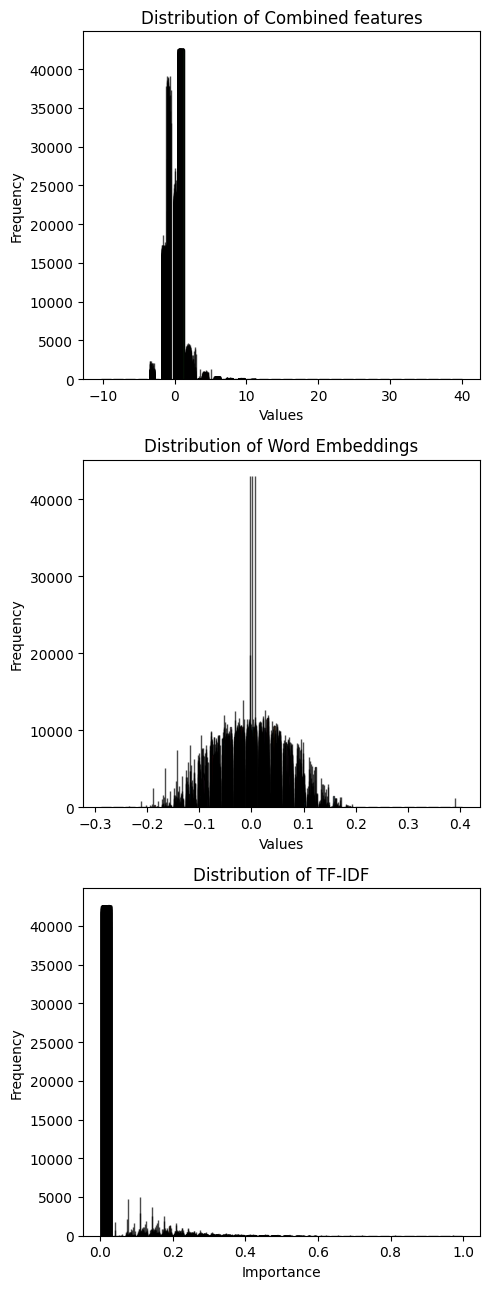

In [45]:
# Values distribution for TF-IDF and Word Embeddings
print("Value Ranges:")
X_train_all_scaled_min = X_train_all_scaled.min().min()
X_train_all_scaled_max = X_train_all_scaled.max().max()
print(f"Combined features: [{X_train_all_scaled_min}, {X_train_all_scaled_max}]")
embed_min = X_train_embed.min().min()
embed_max = X_train_embed.max().max()
print(f"Word Embeddings: [{embed_min}, {embed_max}]")
tf_min = X_train_tf.min().min()
tf_max = X_train_tf.max().max()
print(f"TF-IDF: [{tf_min}, {tf_max}]")


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,13))  # 1 row, 2 columns
# Plotting the first histogram on ax3
ax1.hist(X_train_all_scaled.values, bins=30, edgecolor='k', alpha=0.7)
ax1.set_title('Distribution of Combined features')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')


# Plotting the second histogram on ax2
ax2.hist(X_train_embed.values, bins=30, edgecolor='k', alpha=0.7)
ax2.set_title('Distribution of Word Embeddings')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

# Plotting the first histogram on ax3
ax3.hist(X_train_tf.values, bins=30, edgecolor='k', alpha=0.7)
ax3.set_title('Distribution of TF-IDF')
ax3.set_xlabel('Importance')
ax3.set_ylabel('Frequency')

plt.tight_layout() 
plt.show()


Value Ranges:
Combined features: [0.0, 1.0000000000000002]


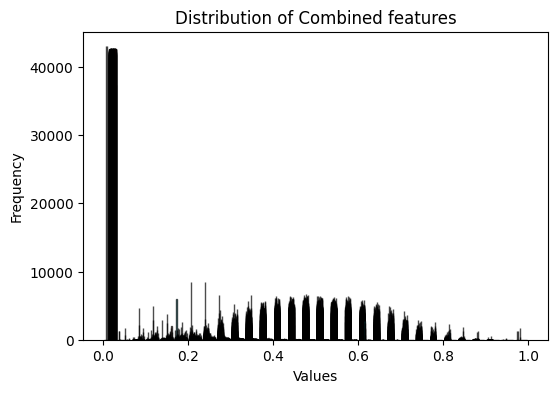

In [6]:
# Values distribution for combined features

# Values distribution for combined features
print("Value Ranges:")
X_train_mnb_base_min = X_train_mnb_base.min().min()
X_train_mnb_base_max = X_train_mnb_base.max().max()
print(f"Combined features: [{X_train_mnb_base_min}, {X_train_mnb_base_max}]")

plt.figure(figsize=(6, 4))
#plt.subplots(1, 2, figsize=(13,4))  # 1 row, 2 columns

# Plotting the second histogram on ax2
plt.hist(X_train_mnb_base.values, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Combined features')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

## Prior Feature Selection

In [6]:
##### Models Prior to Feature Engineering and Feature Selection #####

# Gaussian NB
def gnb_model(X_train, X_vad, y_train):
    estimator = GaussianNB()
    gnb = estimator.fit(X_train, y_train)
    pred = gnb.predict(X_vad)
    return pred, estimator

# Multinominal NB
def mnb_model(X_train, X_vad, y_train):
    estimator = MultinomialNB()
    mnb = estimator.fit(X_train, y_train)
    pred = mnb.predict(X_vad)
    return pred, estimator


In [7]:
gnb_embed_plot_name = "GNB - Word Embeddings"
gnb_tf_plot_name = "GNB - TFIDF"
gnb_all_plot_name = "GNB - All features"
estimator = GaussianNB()
gnb = estimator.fit(X_train_embed, y_train)
print(gnb.classes_)

[-1  1]


### GNB Base Performance

GNB - Word Embeddings
Train scores: [0.8418 0.8453 0.847  0.846  0.8466]
Validation scores: [0.8464 0.8481 0.8472 0.8467 0.8461]


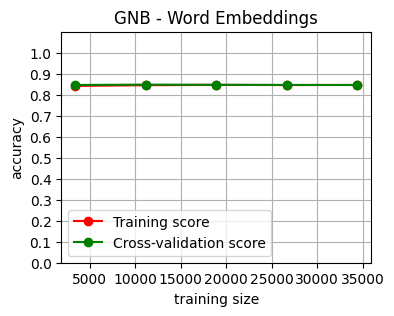

Accuracy:  0.8656
Precision:  0.8241
Recall:  0.8749
F1 :  0.8415
GNB - TFIDF
Train scores: [0.8357 0.8385 0.8361 0.835  0.8366]
Validation scores: [0.8082 0.8294 0.8313 0.8322 0.8329]


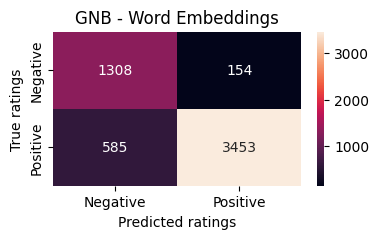

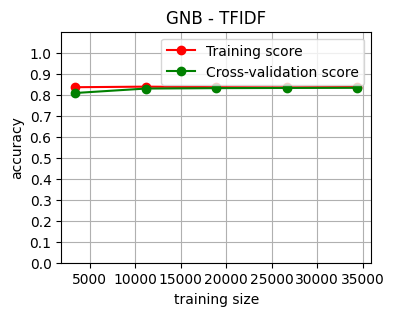

Accuracy:  0.8571
Precision:  0.8154
Recall:  0.8684
F1 :  0.8326
GNB - All features
Train scores: [0.8488 0.8539 0.8514 0.8506 0.8514]
Validation scores: [0.826  0.8452 0.8473 0.8476 0.8484]


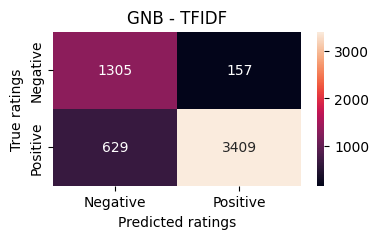

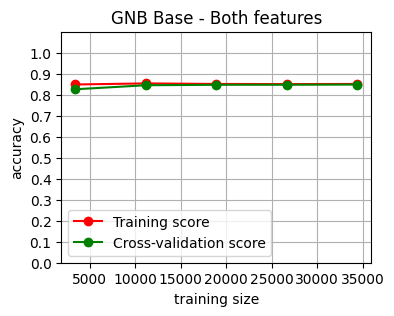

Accuracy:  0.8702
Precision:  0.8292
Recall:  0.8813
F1 :  0.847


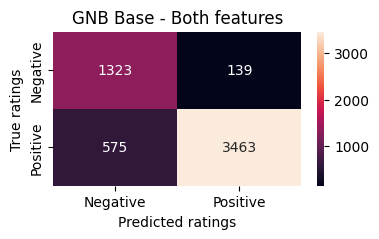

In [60]:
# GNB Word Embedding
gnb_embed_pred, gnb_embed_estimator = gnb_model(X_train_embed, X_vad_embed, y_train)

print(gnb_embed_plot_name)
plot_learning_curve(gnb_embed_plot_name,gnb_embed_estimator, X_train_embed, y_train)
display_performance(gnb_embed_plot_name, gnb_embed_pred, y_vad)

# GNB TFIDF

gnb_tf_pred, gnb_tf_estimator = gnb_model(X_train_tf, X_vad_tf, y_train)
print(gnb_tf_plot_name)
plot_learning_curve(gnb_tf_plot_name,gnb_tf_estimator, X_train_tf, y_train)
display_performance(gnb_tf_plot_name,gnb_tf_pred, y_vad)


#GNB - Both Features
gnb_all_pred, gnb_all_estimator = gnb_model(X_train_all_scaled, X_vad_all_scaled, y_train)
print(gnb_all_plot_name)
plot_learning_curve("GNB Base - Both features",gnb_all_estimator, X_train_all_scaled, y_train)
display_performance("GNB Base - Both features",gnb_all_pred, y_vad)

### MNB Base - Performance

MNB Base - TF-IDF
Train scores: [0.8302 0.8277 0.8299 0.8308 0.8337]
Validation scores: [0.8165 0.827  0.829  0.8294 0.8314]


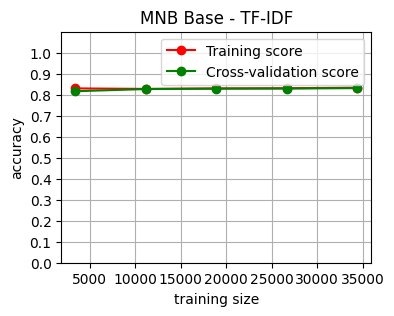

Accuracy:  0.8845
Precision:  0.8809
Recall:  0.8129
F1 :  0.8386
MNB Base - Both Features
Train scores: [0.8635 0.8619 0.8691 0.8724 0.8735]
Validation scores: [0.854  0.8626 0.8688 0.8714 0.8717]


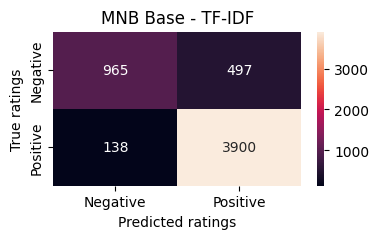

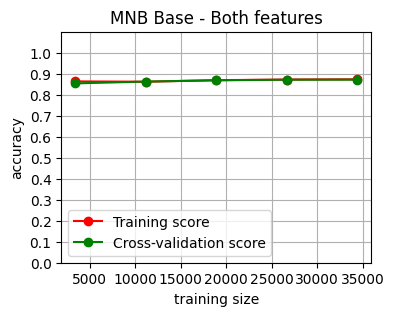

Accuracy:  0.9018
Precision:  0.8816
Recall:  0.8618
F1 :  0.8709


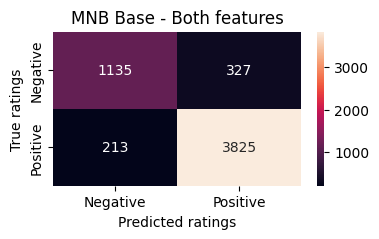

In [63]:
# MNB Word Embedding
# mnb_embed_pred, mnb_embed_estimator = mnb_model(X_train_embed, X_vad_embed, y_train)

# print("MNB Base - Word-Embeddings")
# plot_learning_curve("MNB Base - Word-Embeddings",mnb_embed_estimator, X_train_embed, y_train)
# display_performance("MNB Base - Word-Embeddings", mnb_embed_pred, y_vad)

# MNB TFIDF
mnb_tf_pred, mnb_tf_estimator = mnb_model(X_train_tf, X_vad_tf, y_train)
print("MNB Base - TF-IDF")
plot_learning_curve("MNB Base - TF-IDF",mnb_tf_estimator, X_train_tf, y_train)
display_performance("MNB Base - TF-IDF",mnb_tf_pred, y_vad)


#GNB - Both Features
mnb_all_pred, mnb_all_estimator = mnb_model(X_train_mnb_base, X_vad_mnb_base, y_train)
print("MNB Base - Both Features")
plot_learning_curve("MNB Base - Both features",mnb_all_estimator, X_train_mnb_base, y_train)
display_performance("MNB Base - Both features",mnb_all_pred, y_vad)

In [65]:
print("MNB base - Both feature: ")
mnb_base_pred_FP, mnb_base_pred_FN = getMismatch(mnb_all_pred,10)

MNB base - Both feature: 
False Positive:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
34,33662,1.0,,-1,1
39,33689,0.0,"Staff leaves a lot to be desired and if you have to deal with crap before you get to the a decent doctor, it ain't worth my time.",-1,1
60,33748,1.0,"This doctor is a joke! He misdiagnosed me for a very serious ailment, stated I had MS. On top of if all the office is filthy.",-1,1
70,33763,0.0,". would not recommend this doctor, trained in eastern europe, has careless attitude, does not communicate well",-1,1
169,33999,1.0,I have been seeing Dr. Fahrendorf for years. He always seems to help me with my back problems. He really is a great chiropractor,-1,1
184,34010,0.0,"I did not get the impression that Ms. Folkens has the empathy, knowledge, experience or skills to treat me or others well. I would not recommend her to my friends or family as a neurology provider. The office staff (ie nurses, receptionists) are, however, great.",-1,1
207,34059,1.0,Dr. Falk was not professional and did not seem to know what he was doing.,-1,1
257,34088,1.0,Dr. Goodhope SUCKS!! He spent LESS than 5 minutes in the room with me. I am a VET and deserve better than that. I do not recommend him at all!!!,-1,1
287,34162,1.0,Had to go to Sioux falls to get my arm repaired after Dr. Harbert did surgery,-1,1
307,34183,1.0,Doesn't seem to care. Very cavalier in attitude. Not remotely inquisitive. Can't remember my name despite several visits. Never offers advice. Just goes through the motions and collects his fees.,-1,1


False Negative:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
15,33654,0.0,"I went to Dr Wadud as a new patient in June 2012. Dr Wadud did blood tests on me and suspected from my test results that I had hyperparathyroidism. After sending me for more blood tests, it was confirmed. I had had this disease for many years and previous doctors had missed it over and over again. I have since gone to Dr Norman in Tampa Fl for surgery and am cured. I will be forever grateful to Dr Wadud for her thoroughness &amp; exceptional knowledge.",1,-1
36,33678,1.0,"Doesn't have an on call Dr. number. I was in pain and just wanted to speak to a dentist that knew me, and let them know what was going on. I had to go to an urgent care to get antibiotics sbd pain meds that didn't work.",1,-1
116,33888,1.0,I feel Dr Diamond was very knowlegable and aggressive with his care. My daughter has a very hard time breathing asthema this Dr was the only one out of 5 that got it right. He is prompt very kid friendly. We were an inch from going to Denver Jewish hospital. He gave us his cell phone number and asked us to call anytime we need him. Anytime. We were on a trip and called back home and he called the prescription into a pharmacy on our trip my child was miserable without the medicine. He sits with me and will explain the problem. I would recommend Dr Diamond to anyone who want's a Dr that care's. I my self and daughters go here and will continue to. Friendly staff in the office too. You only wait 10 minutes before being seen.,1,-1
134,33896,0.0,"A. Front desk receptionist unknowledgable and flighty but they changed that. Sitting with sick child in room for an hour and forgot us. No communication between nurses, staff and patients. They made me feel like a bad mom because I chose to leave and take my child home after waiting an hour and a half.",1,-1
171,34004,0.0,"Dr. Angie is a great doctor. She really loves kids and it shows. The problem comes with the wait-time. It is ridiculous to sit in a waiting room for 1 hour and then to be called back to sit in another room for another hour only to see her for 10 minutes. It is rude and unacceptable. Yet, there is a 15 minute late rule, if the patient is late! My kids love going to see her, but I cannot afford to sit in a doctors office for 2 hours for an appointment that should only have 15 -20 minutes. As for the staff, I have never had any issues with the staff. They have always been able to answer my questions or accommodate my request. Now there is a fee to fill out school medical paperwork. what's next&#63; That was the straw that broke the camels back. We went to Patient First right down the street...walked in with no appointment, our first time visiting, saw the doctor, was given the medication and was out within 1 hour. This is what a doctor's office should be like.",1,-1
181,34007,0.0,"She ordered tests, they were performed immediately and she was on the phone to me within 2 hours to let me know I did not have a tumor on the brain. She recommended another dr to do follow up. I went and found out rapidly what was wrong with me. Dr. Florio is a fine Dr. She can be abrupt but she helped me so much when many other doctors could not.",1,-1
185,34013,2.0,Dr. Flaskey is always very thorough. Investigates root cause of problem instead of giving temporary fix.,1,-1
200,34050,1.0,"Great listener, very responsible, took action, improved my quaility of life incredibly so. Uses new methods, new meds. Saw 7 other local docs, he was the first to recognize and act. He took xrays and medicated me responsibly where as others just told me there was no help or they wouldn't help my detriorating health situation. He follows up and has given me new hope and outlook on my health situation. He doesn't promise you the moon and he makes good solid referrals and doesn't waste my money. His referrals are not money suckers and they are very competent people. I just cannot tell you in words how much he has done for me in the 

### Feature Selection

_Using RandomForest_

In [54]:
def feature_searcher(estimator, X_train, y_train, param_grid, percentiles, fold=5):
    # Initialize variables to store the best score and corresponding best features and parameters
    best_score = 0
    best_features = None
    best_params = None
    best_perc = None

    total_iterations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(percentiles)  # 31 percentiles from 50 to 80
    # Iterate over all possible combinations of parameters for RandomForestClassifier
    with tqdm(total=total_iterations) as pbar:
        for params in ParameterGrid(param_grid):
            rf = RandomForestClassifier(**params, criterion='entropy',random_state=0)
            rf.fit(X_train, y_train)
            
            # Get feature importances and select features based on the provided percentile
            importances = rf.feature_importances_

            for p in percentiles:
                perc = np.percentile(importances, p)
                selected_features_name = X_train.columns[importances >= perc]
                X_train_selected = X_train[selected_features_name].copy()
            
            
                scores = cross_val_score(estimator, X_train_selected, y_train, cv=StratifiedKFold(fold), scoring='f1_macro')  

                avg_score = np.mean(scores)
                pbar.update(1)
                # Update the best score, features, and parameters if the current score is better than the best score
                if avg_score > best_score:
                    best_score = avg_score
                    best_features = selected_features_name
                    best_params = params
                    best_perc = p

        print(f"Best Score: {best_score}")
        print(f"Best Features: {list(best_features)}")
        print(f"Best Percentile: {best_perc}")
        print(f"Best RandomForest Parameters: {best_params}")
    return best_features, best_score, best_perc, best_params     

#### MNB

In [55]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 15, 20],
}
percentiles = list(range(50,90,5)) 

mnb_selected_estimator = MultinomialNB()

mnb_best_features, mnb_best_score, mnb_best_perc, mnb_best_params = feature_searcher(mnb_selected_estimator, X_train_mnb_base, y_train, param_grid, percentiles=percentiles)

100%|██████████| 96/96 [1:09:36<00:00, 43.50s/it] 

Best Score: 0.8577986502181684
Best Features: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152',

In [56]:
best_feat_1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 
'15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', 
'31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', 
'47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', 
'63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', 
'79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', 
'95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', 
'109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', 
'123', '124', '125', '126', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', 
'138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', 
'152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', 
'166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', 
'180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', 
'194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', 
'208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', 
'222', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', 
'237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', 
'251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', 
'265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', 
'279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', 
'293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', 
'307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', 
'321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', 
'335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', 
'349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', 
'363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', 
'377', '378', '379', '380', '381', '382', '383', 'arrogant', 'asked', 'bad', 'best', 'caring', 
'comfortable', 'did', 'didn', 'doctor', 'doctors', 'does', 'doesn', 'don', 'dr', 'excellent', 
'feel', 'friendly', 'good', 'great', 'helped', 'helpful', 'highly', 'horrible', 'just', 'kind', 
'knowledgeable', 'left', 'like', 'listen', 'listens', 'love', 'money', 'nice', 'office', 'opinion', 
'pain', 'patient', 'patients', 'poor', 'professional', 'quot', 'recommend', 'room', 'rude', 'said', 
'staff', 'takes', 'terrible', 'thank', 'thorough', 'time', 'told', 'took', 'unprofessional', 'waste', 
'went', 'wonderful', 'worst', 'wrong', 'years']

In [57]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 15, 20],
}
percentiles = list(range(5,50,5)) 

mnb_selected_estimator = MultinomialNB()

mnb_best_features_v2, mnb_best_score_v2, mnb_best_perc_v2, mnb_best_params_v2 = feature_searcher(mnb_selected_estimator, X_train_mnb_base, y_train, param_grid, percentiles=percentiles)

100%|██████████| 108/108 [1:13:37<00:00, 40.91s/it] 


Best Score: 0.8713107637804981
Best Features: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152',

In [58]:
best_feat_mnb_v2 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '10', '100', '15', '20', '63', 'able', 'actually', 'ago', 'agree', 'amazing', 'amp', 'answer', 'answered', 'answers', 'appointment', 'appointments', 'appt', 'area', 'arrogant', 'ask', 'asked', 'asking', 'assistant', 'attitude', 'avoid', 'away', 'awesome', 'baby', 'bad', 'bedside', 'believe', 'best', 'better', 'big', 'bit', 'blood', 'breast', 'business', 'busy', 'called', 'calls', 'came', 'cancer', 'care', 'cares', 'caring', 'case', 'change', 'changed', 'check', 'child', 'children', 'clinic', 'cold', 'come', 'comfortable', 'comments', 'company', 'compassionate', 'complete', 'concern', 'concerned', 'concerns', 'condition', 'continue', 'correct', 'couldn', 'couple', 'daughter', 'day', 'days', 'deal', 'decided', 'delivered', 'dentist', 'desk', 'diagnosed', 'diagnosis', 'did', 'didn', 'different', 'discuss', 'disease', 'doc', 'doctor', 'doctors', 'does', 'doesn', 'doing', 'don', 'dont', 'door', 'dr', 'ease', 'easy', 'emergency', 'end', 'ended', 'entire', 'er', 'exam', 'excellent', 'experience', 'explain', 'explained', 'explaining', 'extremely', 'eye', 'face', 'fact', 'family', 'fantastic', 'far', 'father', 'feel', 'feeling', 'felt', 'finally', 'fine', 'fix', 'follow', 'free', 'friend', 'friendly', 'friends', 'gave', 'getting', 'given', 'god', 'goes', 'going', 'gone', 'good', 'got', 'great', 'guy', 'gyn', 'half', 'happy', 'hard', 'having', 'head', 'health', 'hear', 'heard', 'heart', 'help', 'helped', 'helpful', 'helping', 'high', 'highly', 'home', 'hope', 'horrible', 'hospital', 'hour', 'hours', 'humor', 'husband', 'immediately', 'important', 'impressed', 'information', 'informed', 'instead', 'insurance', 'interested', 'isn', 'issue', 'issues', 'job', 'just', 'kept', 'kids', 'kind', 'knew', 'know', 'knowledgable', 'knowledge', 'knowledgeable', 'known', 'knows', 'lab', 'late', 'later', 'leave', 'left', 'let', 'life', 'like', 'listen', 'listened', 'listens', 'little', 'long', 'longer', 'look', 'looked', 'looking', 'lost', 'lot', 'love', 'make', 'makes', 'making', 'man', 'manner', 'maybe', 'medical', 'medication', 'medications', 'medicine', 'meds', 'met', 'mind', 'minutes', 'mom', 'money', 'month', 'months', 'mother', 'mri', 'necessary', 'need', 'needed', 'needs', 'negative', 'new', 'nice', 'nurse', 'office', 'old', 'open', 'opinion', 'options', 'outstanding', 'overall', 'pa', 'paid', 'pain', 'patient', 'patients', 'pay', 'people', 'performed', 'person', 'personable', 'personally', 'phone', 'physical', 'physician', 'place', 'plan', 'pleasant', 'pleased', 'point', 'polite', 'poor', 'possible', 'post', 'practice', 'pregnancy', 'pregnant', 'prescribed', 'prescription', 'previous', 'prior', 'probably', 'problem', 'problems', 'procedure', 'professional', 'quality', 'question', 'questions', 'quick', 'quickly', 'quite', 'quot', 'rate', 'read', 'real', 'really', 'reason', 'received', 'recently', 'receptionist', 'recommend', 'recommended', 'records', 'referred', 'refused', 'removed', 'research', 'respect', 'results', 'return', 'right', 'room', 'rude', 'run', 'rushed', 'said', 'saved', 'saw', 'say', 'saying', 'says', 'scheduled', 'second', 'seeing', 'seen', 'sent', 'service', 'sick', 'situation', 'skills', 'skin', 'son', 'speak', 'specialist', 'spend', 'spends', 'spent', 'staff', 'started', 'state', 'stay', 'stuff', 'sure', 'surgeon', 'surgeries', 'surgery', 'symptoms', 'taken', 'takes', 'taking', 'talk', 'talking', 'tell', 'telling', 'terrible', 'test', 'tests', 'thank', 'thanks', 'thing', 'things', 'think', 'thorough', 'thought', 'time', 'times', 'today', 'told', 'took', 'tooth', 'town', 'treat', 'treated', 'treatment', 'treatments', 'treats', 'tried', 'truly', 'trust', 'try', 'trying', 'twice', 'type', 'understand', 'understanding', 'unprofessional', 'use', 'used', 'usually', 've', 'visit', 'visits', 'wait', 'waited', 'waiting', 'walk', 'want', 'wanted', 'wants', 'wasn', 'waste', 'way', 'week', 'weeks', 'weight', 'went', 'wife', 'willing', 'wish', 'woman', 'won', 'wonderful', 'work', 'worked', 'working', 'works', 'worse', 'worst', 'worth', 'wouldn', 'wrong', 'year', 'years', 'yes', 'young']

After feature selection using RandomForest
MNB - ALL feature - performance
Train scores: [0.8567 0.8611 0.8696 0.8712 0.8728]
Validation scores: [0.8528 0.8621 0.8707 0.8707 0.8713]


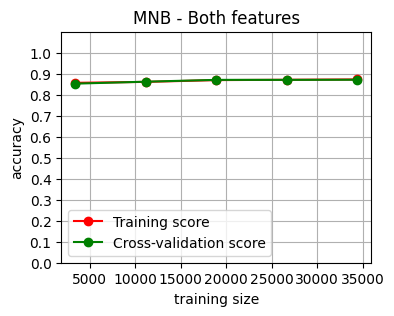

Accuracy:  0.9031
Precision:  0.8844
Recall:  0.862
F1 :  0.8722


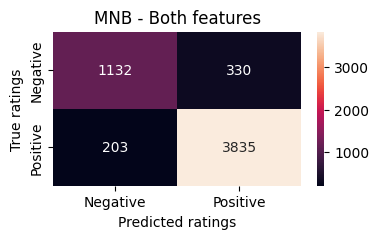

In [59]:
print("After feature selection using RandomForest")
print("MNB - ALL feature - performance")
mnb_all_pred_final, mnb_all_estimator_final = mnb_model(X_train_mnb_base[best_feat_mnb_v2], X_vad_mnb_base[best_feat_mnb_v2], y_train)
plot_learning_curve("MNB - Both features", mnb_all_estimator_final, X_train_mnb_base[best_feat_mnb_v2], y_train)
display_performance("MNB - Both features", mnb_all_pred_final, y_vad)

In [7]:
# Given train and validation scores
train_scores = np.array([0.8567, 0.8611, 0.8696, 0.8712, 0.8728])
validation_scores = np.array([0.8528, 0.8621, 0.8707, 0.8707, 0.8713])

# Calculate the mean for train and validation scores
mean_train_score = np.mean(train_scores)
mean_validation_score = np.mean(validation_scores)

# Calculate the difference between the means
mean_difference = mean_train_score - mean_validation_score

mean_train_score, mean_validation_score, mean_difference


(0.86628, 0.8655200000000001, 0.0007599999999999829)

In [66]:
print("Post Feature Selection\nMNB - Both Features")
mnb_all_pred_post_FP, mnb_all_pred_post_FN = getMismatch(mnb_all_pred_final, 10)

Post Feature Selection
MNB - Both Features
False Positive:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
34,33662,1.0,,-1,1
39,33689,0.0,"Staff leaves a lot to be desired and if you have to deal with crap before you get to the a decent doctor, it ain't worth my time.",-1,1
60,33748,1.0,"This doctor is a joke! He misdiagnosed me for a very serious ailment, stated I had MS. On top of if all the office is filthy.",-1,1
70,33763,0.0,". would not recommend this doctor, trained in eastern europe, has careless attitude, does not communicate well",-1,1
165,33981,0.0,"Puts people on diabetic drugs when the A1C is only 7.5, and Januvia is known to cause pancreatitis.",-1,1
169,33999,1.0,I have been seeing Dr. Fahrendorf for years. He always seems to help me with my back problems. He really is a great chiropractor,-1,1
184,34010,0.0,"I did not get the impression that Ms. Folkens has the empathy, knowledge, experience or skills to treat me or others well. I would not recommend her to my friends or family as a neurology provider. The office staff (ie nurses, receptionists) are, however, great.",-1,1
207,34059,1.0,Dr. Falk was not professional and did not seem to know what he was doing.,-1,1
257,34088,1.0,Dr. Goodhope SUCKS!! He spent LESS than 5 minutes in the room with me. I am a VET and deserve better than that. I do not recommend him at all!!!,-1,1
287,34162,1.0,Had to go to Sioux falls to get my arm repaired after Dr. Harbert did surgery,-1,1


False Negative:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
15,33654,0.0,"I went to Dr Wadud as a new patient in June 2012. Dr Wadud did blood tests on me and suspected from my test results that I had hyperparathyroidism. After sending me for more blood tests, it was confirmed. I had had this disease for many years and previous doctors had missed it over and over again. I have since gone to Dr Norman in Tampa Fl for surgery and am cured. I will be forever grateful to Dr Wadud for her thoroughness &amp; exceptional knowledge.",1,-1
36,33678,1.0,"Doesn't have an on call Dr. number. I was in pain and just wanted to speak to a dentist that knew me, and let them know what was going on. I had to go to an urgent care to get antibiotics sbd pain meds that didn't work.",1,-1
116,33888,1.0,I feel Dr Diamond was very knowlegable and aggressive with his care. My daughter has a very hard time breathing asthema this Dr was the only one out of 5 that got it right. He is prompt very kid friendly. We were an inch from going to Denver Jewish hospital. He gave us his cell phone number and asked us to call anytime we need him. Anytime. We were on a trip and called back home and he called the prescription into a pharmacy on our trip my child was miserable without the medicine. He sits with me and will explain the problem. I would recommend Dr Diamond to anyone who want's a Dr that care's. I my self and daughters go here and will continue to. Friendly staff in the office too. You only wait 10 minutes before being seen.,1,-1
134,33896,0.0,"A. Front desk receptionist unknowledgable and flighty but they changed that. Sitting with sick child in room for an hour and forgot us. No communication between nurses, staff and patients. They made me feel like a bad mom because I chose to leave and take my child home after waiting an hour and a half.",1,-1
171,34004,0.0,"Dr. Angie is a great doctor. She really loves kids and it shows. The problem comes with the wait-time. It is ridiculous to sit in a waiting room for 1 hour and then to be called back to sit in another room for another hour only to see her for 10 minutes. It is rude and unacceptable. Yet, there is a 15 minute late rule, if the patient is late! My kids love going to see her, but I cannot afford to sit in a doctors office for 2 hours for an appointment that should only have 15 -20 minutes. As for the staff, I have never had any issues with the staff. They have always been able to answer my questions or accommodate my request. Now there is a fee to fill out school medical paperwork. what's next&#63; That was the straw that broke the camels back. We went to Patient First right down the street...walked in with no appointment, our first time visiting, saw the doctor, was given the medication and was out within 1 hour. This is what a doctor's office should be like.",1,-1
181,34007,0.0,"She ordered tests, they were performed immediately and she was on the phone to me within 2 hours to let me know I did not have a tumor on the brain. She recommended another dr to do follow up. I went and found out rapidly what was wrong with me. Dr. Florio is a fine Dr. She can be abrupt but she helped me so much when many other doctors could not.",1,-1
200,34050,1.0,"Great listener, very responsible, took action, improved my quaility of life incredibly so. Uses new methods, new meds. Saw 7 other local docs, he was the first to recognize and act. He took xrays and medicated me responsibly where as others just told me there was no help or they wouldn't help my detriorating health situation. He follows up and has given me new hope and outlook on my health situation. He doesn't promise you the moon and he makes good solid referrals and doesn't waste my money. His referrals are not money suckers and they are very competent people. I just cannot tell you in words how much he has done for me in the last two years over the past ten years of dealing with my health issue with other doctors. He doesn't play the come in every

### GNB

In [45]:
gnb_selected_estimator_all = GaussianNB()
best_features_all, best_score_all, best_perc_all, best_params_all = feature_searcher(gnb_selected_estimator_all, X_train_all_scaled, y_train, param_grid, percentiles=percentiles)

100%|██████████| 96/96 [1:17:03<00:00, 48.17s/it] 

Best Score: 0.8710035254327912
Best Features: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151',

In [25]:

best_features_all = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '63', 'arrogant', 'asked', 'bad', 'best', 'caring', 'cold', 'did', 'didn', 'doctor', 'does', 'doesn', 'don', 'dr', 'excellent', 'feel', 'friendly', 'good', 'great', 'helped', 'helpful', 'highly', 'horrible', 'kind', 'knowledgeable', 'left', 'like', 'listens', 'love', 'money', 'office', 'pain', 'patient', 'patients', 'poor', 'problem', 'quot', 'recommend', 'refused', 'room', 'rude', 'said', 'saved', 'staff', 'takes', 'terrible', 'thorough', 'time', 'told', 'took', 'unprofessional', 'wait', 'waste', 'went', 'wonderful', 'worst', 'wrong', 'years']


After feature selection using RandomForest
GNB - ALL feature - performance
Train scores: [0.8642 0.8647 0.868  0.8691 0.871 ]
Validation scores: [0.8687 0.8707 0.8706 0.8709 0.871 ]


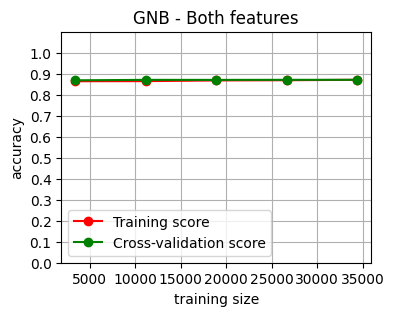

Accuracy:  0.8851
Precision:  0.8454
Recall:  0.8925
F1 :  0.8629


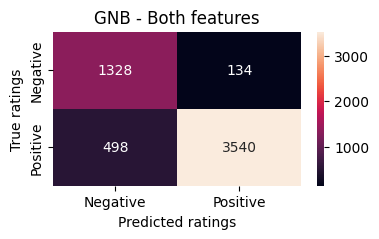

In [37]:
print("After feature selection using RandomForest")
print("GNB - ALL feature - performance")
gnb_all_pred_v1, gnb_all_estimator_v1 = gnb_model(X_train_all_scaled[best_features_all], X_vad_all_scaled[best_features_all], y_train)
plot_learning_curve("GNB - Both features", gnb_all_estimator_v1, X_train_all_scaled[best_features_all], y_train)
display_performance("GNB - Both features", gnb_all_pred_v1, y_vad)

In [35]:
print("Post Feature Selection\nGNB - Both Features")
gnb_all_pred_post_FP, gnb_all_pred_post_FN = getMismatch(gnb_all_pred_v1, 10)

Post Feature Selection
GNB - Both Features
False Positive:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
70,33763,0.0,". would not recommend this doctor, trained in eastern europe, has careless attitude, does not communicate well",-1,1
112,33888,1.0,doctor should do his job and not accuse me of taking pain meds. Than the doctor found out I just had surgery. NO SORRY... All that he had to say was don't ask me for anything... wichI never did or was going to. I highly do not recommend this doctor! He will Judge you the minute you walk in. as well as I have been sitting here now for three hours. I wrote this while waiting..,-1,1
169,33999,1.0,I have been seeing Dr. Fahrendorf for years. He always seems to help me with my back problems. He really is a great chiropractor,-1,1
184,34010,0.0,"I did not get the impression that Ms. Folkens has the empathy, knowledge, experience or skills to treat me or others well. I would not recommend her to my friends or family as a neurology provider. The office staff (ie nurses, receptionists) are, however, great.",-1,1
299,34174,1.0,"Went in for a same-day surgery to remove fallopian tube. Hansen recommended laparoscopy. I signed a form advising Hansen to STOP if he encountered any scar tissue & cut me open instead so he could see where he was cutting. I have severe internal scarring, which he was fully aware of. He encountered major scarring, but continued to cut and knicked my bowel. He admitted to TRAUMA SURGEON that he continued through a wall of scar tissue. Hansen sent me home after the surgery. The next morning after a painful, sleepless night of several phone calls to Hansen, he tells me I was just not tolerating the pain well. I was vomiting every time I took pain med or a sip of water & couldn't keep anything down. He suggested I wait until his clinic opened to come in. Went in that a.m. Two days later, being fed anti-nausea & pain meds in the hospital instead of finding out what the cause was, the nurse stood me up & bowel contents poured from my surgical wounds. Dr. Timmerman BARELY saved my life...",-1,1
327,34201,1.0,"My experience was not as well as these other seemingly happy people. Niiicccee doctor, nice",-1,1
367,34224,1.0,I would not recommend this doctor to anyone.,-1,1
406,34242,0.0,"She was very helpful and caring in the beginning of my diagnosis. By the time I started chemo she was very RUDE, UNCARING &amp; DISRESPECTFUL . She spent most of our office visits chewing me out. Her fill-in Dr treated me more then she did. This Dr was VERY Caring &amp; Concerned for me and has helped me the most during my breast cancer visits! I feel Dr. Krie overwhelmed me with kindness in the beginning so I would choose her n the facility to treat my Cancer. And I believed once Dr Krie felt I gained her trust, is when Krie's attitude twords me went negative! I thank God every day for Margret (fill-in Dr). She was the Greatest. I just wish Margret could finish my treatments. . .",-1,1
511,34416,1.0,wouldnt recommend at all . I still have the problem after numerous visit to him.,-1,1
531,34446,1.0,"Not helpful when you need answers. Does not pick up the phone, leaves you hanging. He'll be there to cut though, after that he's done with you.I think he's a good dr, but only in the OR.",-1,1


False Negative:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
6,33636,0.0,"I had much better experience with Dr. Durant than a much more popular pediatric dentist in town. She was good, some of her office staff was new and didn't know some things, but was still helpful and didn't stop until she found the right answer.",1,-1
9,33643,2.0,,1,-1
15,33654,0.0,"I went to Dr Wadud as a new patient in June 2012. Dr Wadud did blood tests on me and suspected from my test results that I had hyperparathyroidism. After sending me for more blood tests, it was confirmed. I had had this disease for many years and previous doctors had missed it over and over again. I have since gone to Dr Norman in Tampa Fl for surgery and am cured. I will be forever grateful to Dr Wadud for her thoroughness &amp; exceptional knowledge.",1,-1
16,33654,0.0,"The woman who greets you is not friendly. Never smiles. Very abrupt. The nurse is fantastic. Dr. Wadud is fabulous! The wait time is terrible. Everyone in the waiting room complains. Never enough chairs to sit on in the main waiting room. Smoking is allowed right outside the door you have to enter. The nurse and Dr. Wadud are wonderful, they just need to replace the office staff.",1,-1
17,33659,1.0,The absolute rudest front desk staff I have ever encountered. Once you get back to see the doctor it is fine but the office staff makes you really want to find another doctor.,1,-1
36,33678,1.0,"Doesn't have an on call Dr. number. I was in pain and just wanted to speak to a dentist that knew me, and let them know what was going on. I had to go to an urgent care to get antibiotics sbd pain meds that didn't work.",1,-1
57,33746,2.0,,1,-1
63,33758,1.0,"After 20yr. of back pain,Dr.Z was the only Doctor that tryed to find out why I had so much pain. He is the most understanding person,and will do anything he can to help you. I will never forget this man or his staff for what they did for me.",1,-1
84,33810,0.0,"I met Dr Alpers when I had a lump in my breast. I was very afraid when they did that work on me, but Dr Alpers was so nice and kind. She explained what they were doing and did it in a way that I could understand. She is so smart! I was really scared, bur Dr. Alpers made it much better. I asked my family Dr about her and he said, &quot;She is always so good that way with people. &quot; And everything came out so good!",1,-1
95,33863,1.0,"Dr Akerson was great. Appeared knowledgeable, willing to sit and explain, and the result was as promised. His staff was terrible. Rude, insulting, arrogant. I'm honestly not certain going to him is worth putting up with them.",1,-1
